## Data Wrangling

In [154]:
import boto3
import sagemaker
from pyathena import connect
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
from geopy.geocoders import Nominatim
import geopandas
import tensorflow as tf
import scipy
from sagemaker import get_execution_role
from scipy.sparse import csr_matrix

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


### Create and Verify Database

In [155]:
# Make athena db
sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [65]:
ingest_create_athena_db_passed = False

In [66]:
# Set db name
database_name = "crops"

In [67]:
# Set S3 staging directory - temporary directory used for athena
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [68]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [69]:
# Create the Database
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS crops


""


In [70]:
# Make sure it was created
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head()

,database_name
0,crops
1,default
2,sagemaker_featurestore


In [71]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

### Create Athena for Merged DB

In [72]:
# Athena parameters
table_name_csv = "merged_df"
s3_private_path_csv = "s3://sagemaker-studio-998234604495-nyhifbo32oo/merged/"
table_name_parquet = "merged_df_parquet"
s3_path_parquet = "s3://sagemaker-studio-998234604495-nyhifbo32oo/parquet/"


In [73]:
# Create athena table based on merged data
statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
        Area string,
        Item string,
        year integer,
        production integer,
        nitrogen integer,
        phosphate integer,
        potassium integer,
        value float,
        avg_rain float,
        avg_temp float,
        total_value_usd float
        
        
) ROW FORMAT DELIMITED FIELDS TERMINATED BY ',' LINES TERMINATED BY '\\n' LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_private_path_csv
)

pd.read_sql(statement, conn)

""


In [74]:
# Look at the dataset
statement = """SELECT * FROM {}.{}
    LIMIT 5""".format(
    database_name, table_name_csv
)

print(statement)

test= pd.read_sql(statement, conn)
test.head()

SELECT * FROM crops.merged_df
    LIMIT 5


,area,item,year,production,nitrogen,phosphate,potassium,value,avg_rain,avg_temp,total_value_usd
0,Albania,Apples,1991,10000,22300,7700,1300,None,1485.0,15.36,None
1,Albania,Apricots,1991,1200,22300,7700,1300,None,1485.0,15.36,None
2,Albania,Barley,1991,3323,22300,7700,1300,None,1485.0,15.36,None
3,Albania,Beans dry,1991,12844,22300,7700,1300,None,1485.0,15.36,None
4,Albania,Broad beans and horse beans green,1991,0,22300,7700,1300,None,1485.0,15.36,None


# Exploratory Data Analysis

In [75]:
### Save as df to potentially save cost
statement = """SELECT * FROM {}.{}""".format(
    database_name, table_name_csv
)

df= pd.read_sql(statement, conn)

In [76]:
print("There are", df.shape[0], "rows in the data frame and", df.shape[1], "columns")

There are 113454 rows in the data frame and 11 columns


## Adding in Geographic Data
Since we're using location as a predictor, we'll need to grab the coordinates of each country. There are also regions that we'll need to delete

In [77]:
# Functions to find coordinates
geolocater = Nominatim(user_agent="geoapiExercise")
def geolocate_lat(area):
    try:
        # Center of country
        loc = geolocater.geocode(area)
        # Return coords
        return (loc.latitude)
    except:
        return np.nan
    
def geolocate_long(area):
    try:
        # Center of country
        loc = geolocater.geocode(area)
        # Return coords
        return (loc.longitude)
    except:
        return np.nan

In [78]:
# Get the coordinates and build df for them
countries = df['area'].unique()
countries = pd.Series(countries)

latitudes = countries.apply(geolocate_lat)
longitudes = countries.apply(geolocate_long)

coord = pd.DataFrame(list(zip(countries, latitudes, longitudes)),
             columns=['area', 'lat', 'long'])

In [79]:
# Merge our data
df = pd.merge(df, coord, left_on=['area'], right_on=['area'], how="inner")

## NA Analysis

In [80]:
nan_count = df.isna().sum()
print(nan_count)

area                   0
item                   0
year                   0
production          2570
nitrogen            2149
phosphate           4453
potassium           5433
value              40675
avg_rain               0
avg_temp               0
total_value_usd    40918
lat                    0
long                   0
dtype: int64


The large amount of NAs in total_value_usd appears to be from value. Likely a country not reporting in USD or based on the year. Either one would be fairly hard to get the correct value as we would need to look up the conversion rates for every country at the specific times.

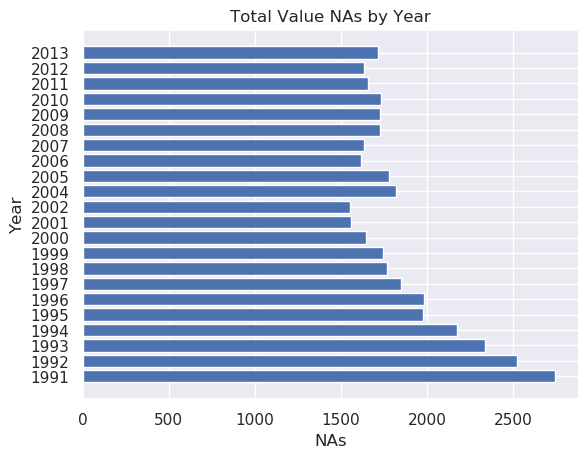

In [81]:
# By Year
na_year = df.total_value_usd.isnull().groupby(df['year']).sum().astype(int).reset_index(name="count")
na_year['year'] = na_year['year'].astype(object)

bars = na_year['year']
height = na_year['count']
y_pos = np.arange(len(bars))

plt.clf()
plt.barh(y_pos, height)

plt.title("Total Value NAs by Year")
plt.ylabel("Year")
plt.xlabel("NAs")
plt.yticks(y_pos, bars)
plt.show()

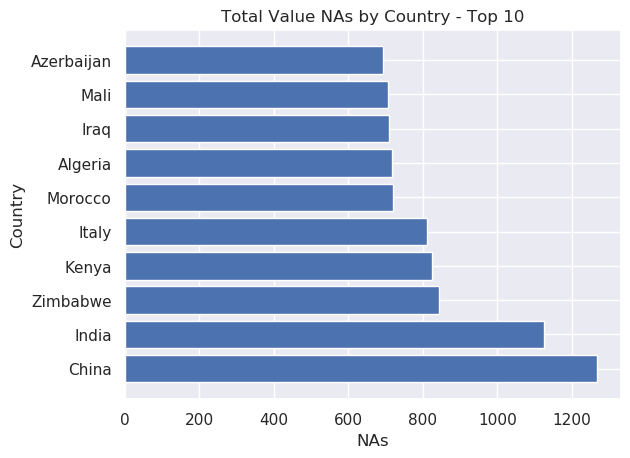

In [82]:
# By Country
na_country = df.total_value_usd.isnull().groupby(df['area']).sum().astype(int).reset_index(name="count")
na_country = na_country.sort_values(by=['count'], ascending=False).head(10)


bars = na_country['area']
height = na_country['count']
y_pos = np.arange(len(bars))

plt.clf()
plt.barh(y_pos, height)

plt.title("Total Value NAs by Country - Top 10")
plt.ylabel("Country")
plt.xlabel("NAs")
plt.yticks(y_pos, bars)
plt.show()

It looks like India may have some issues if we remove the NAs. We'll check to see how many observations are left when we remove NAs.

Looks like we'll still be fine leaving India in. 

In [83]:
df_nona = df.dropna()
df_nona_china = df_nona[df_nona['area'] == "China"]
df_china = df[df['area'] == "China"]

print("China loses", df_china.shape[0] - df_nona_china.shape[0], "observations when we take out NAs leaving us with", df_nona_china.shape[0], "observations left for the country")

China loses 1268 observations when we take out NAs leaving us with 1460 observations left for the country


### Final clean before EDA
As we'll see below, fertilizers are fairly related to each other so we should be able to impute those missing values in a pipeline later. It likely isn't appropriate to impute the large number of missing total_value_usd's, so we will delete those.

In [84]:
df_clean = df[df['total_value_usd'].notna()]

# Note - we still expect to have nas for fertilizers since we're imputing those
nan_count = df_clean.isna().sum()
print(nan_count)

area                  0
item                  0
year                  0
production            0
nitrogen            173
phosphate          1376
potassium          1615
value                 0
avg_rain              0
avg_temp              0
total_value_usd       0
lat                   0
long                  0
dtype: int64


## Target Variable - total_value_usd 
The target variable is the production (in tonnes) multiplied by the value (United States Dollar per tonne).

### Distribution 
Our target is very skewed to the right. Not suprising given that some crops likely produce a lot more value than most (for example corn in the USA is likely very high valued). Need to consider scaling after splitting.

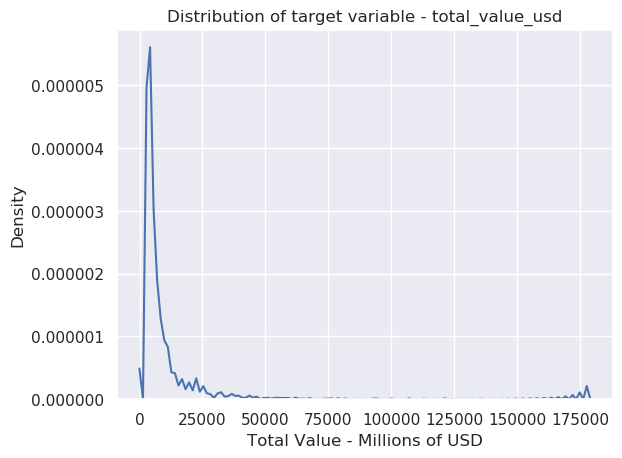

In [85]:
sns.set(style = "darkgrid")
sns.distplot(a = df_clean['total_value_usd']/1_000_000, hist = False, kde = True, rug = False)
plt.xlabel("Total Value - Millions of USD")
plt.ylabel("Density")
plt.title("Distribution of target variable - total_value_usd")
plt.show()

## Numeric Predictors 
The numeric predictors include the fertilizers used for agricultural purposes (nitrogen, phosphate, and potassium) and the weather featrues (avg_temp and avg_rain)

Fertilizer Distributions -
Still skewed heavily to the right, we'll likely need to make pipeline to standardize all numeric features

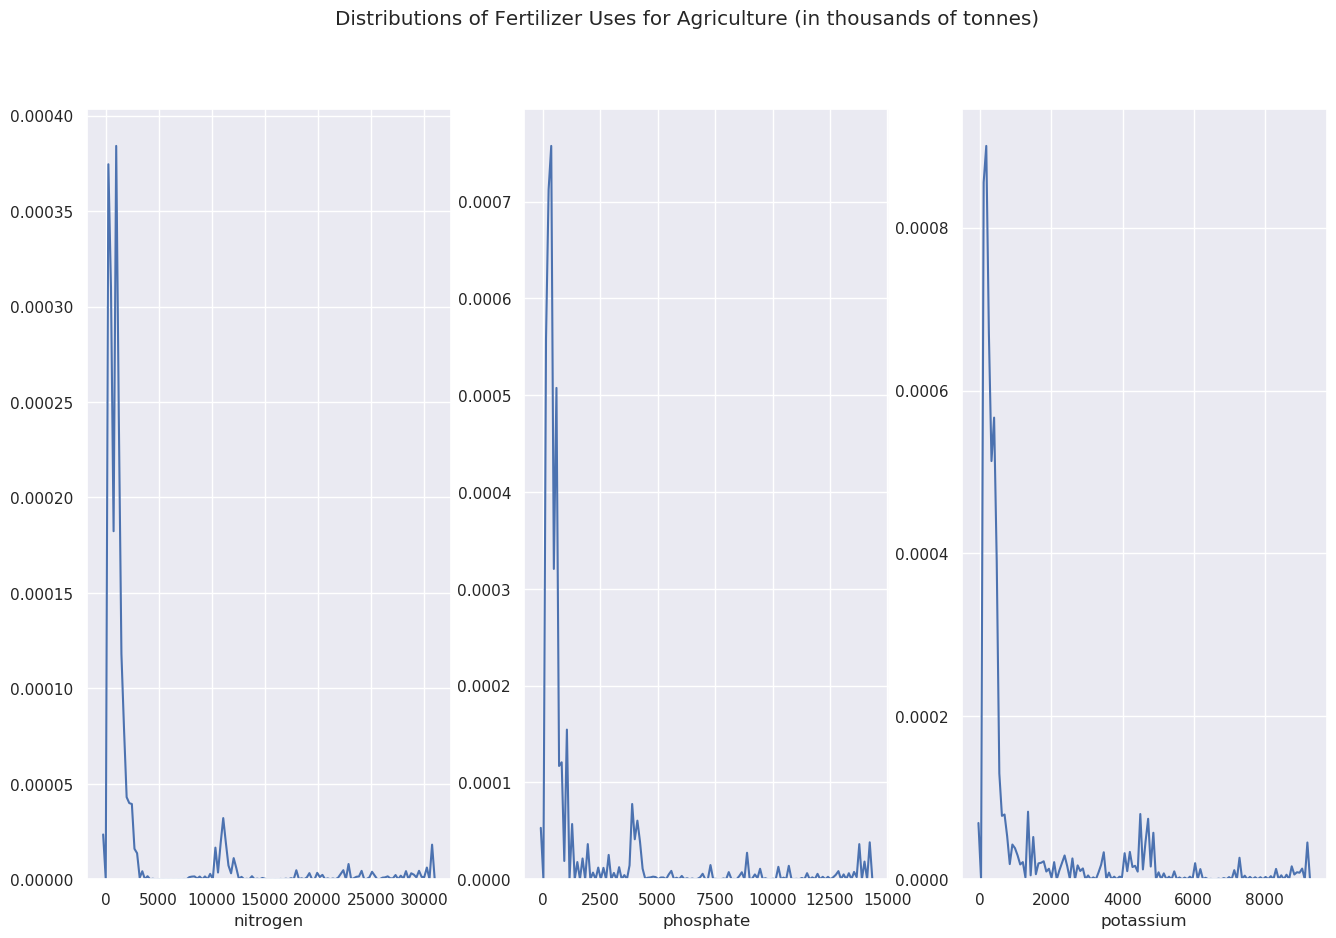

In [86]:
fig, axes = plt.subplots(1,3, figsize=(16,10))

fig.suptitle("Distributions of Fertilizer Uses for Agriculture (in thousands of tonnes)")

sns.distplot(ax = axes[0], a = df_clean['nitrogen']/1_000, hist = False, kde = True, rug = False)
sns.distplot(ax = axes[1], a = df_clean['phosphate']/1_000, hist = False, kde = True, rug = False)
sns.distplot(ax = axes[2], a = df_clean['potassium']/1_000, hist = False, kde = True, rug = False)

plt.show()


Weather Predictors - These Look a lot better than other variables, regardless a standardization pipeline that works on all numeric features is still probbaly the most efficient option.

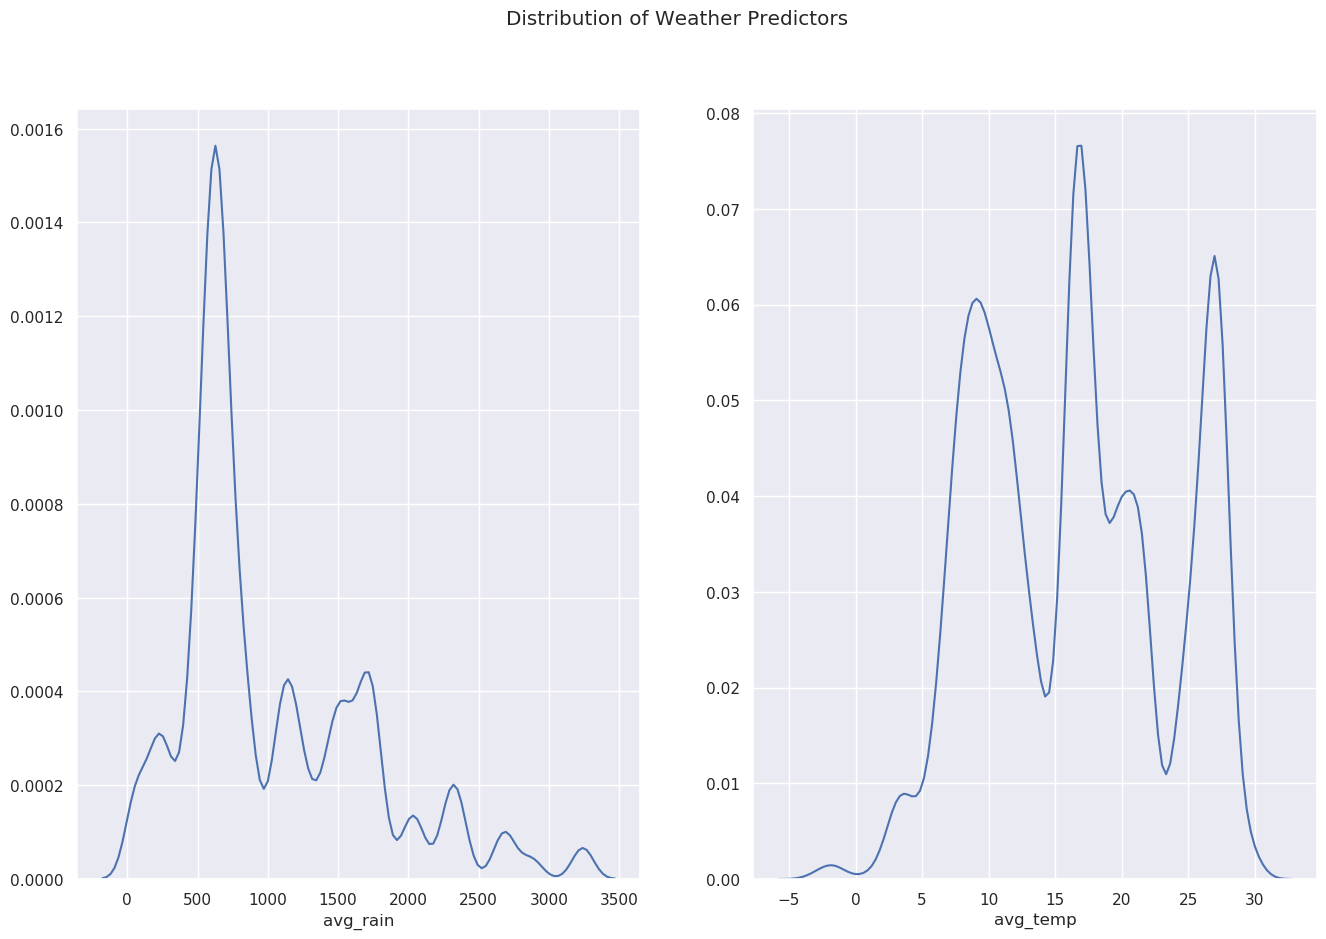

In [87]:
fig, axes = plt.subplots(1,2, figsize=(16,10))

fig.suptitle("Distribution of Weather Predictors")

sns.distplot(ax = axes[0], a = df_clean['avg_rain'], hist = False, kde = True, rug = False)
sns.distplot(ax = axes[1], a = df_clean['avg_temp'], hist = False, kde = True, rug = False)

plt.show()

Correlation Matrix for Numeric Features

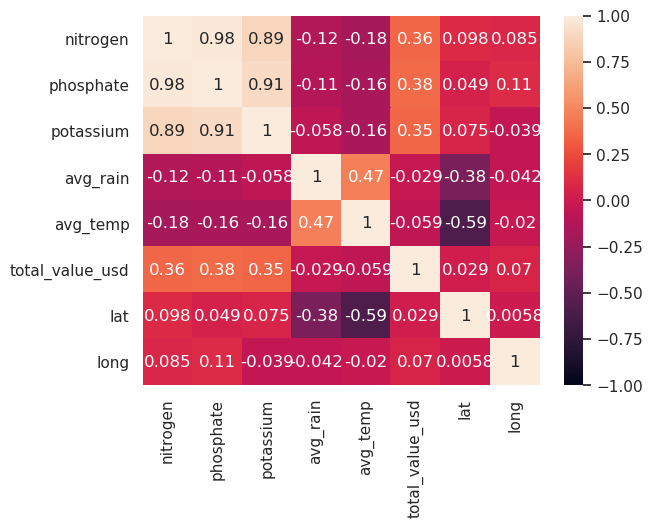

In [88]:
df_numeric = df_clean.select_dtypes(['int64', 'float64'])
df_numeric = df_numeric.drop(columns=['year', 'production', 'value'], axis=1)
df_numeric_nona = df_numeric.dropna()


plt.clf()
sns.heatmap(df_numeric_nona.corr(), vmin= -1, vmax=1, annot=True)
plt.show()

## Maps
Doing the maps down here since we have NAs sorted out now.

Bring in our world data

In [89]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

#### Fix Country names:
Some names aren't matching between world and df, need to match them since we're merging on them.

In [90]:
world['name'].unique();

In [91]:
world_country = ['United States of America', 'Dem. Rep. Congo', 'Congo']
df_country = ["United States", "Congo, Dem. Rep.", "Congo, Rep."]

world2 = world

for (old, new) in zip(world_country, df_country):
    world2['name'] = world['name'].replace(old,new)



### Highest Ag Value 1991-2013

In [92]:
val_country = df_clean.groupby(by="area")["total_value_usd"].sum()

countries = df_clean['area'].unique()
countries = pd.Series(countries)

geos = world2[['name', 'geometry']]
geos

val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_value = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

In [93]:
gdf_value['value'] = gdf_value[['value']]/1_000_000_000_000

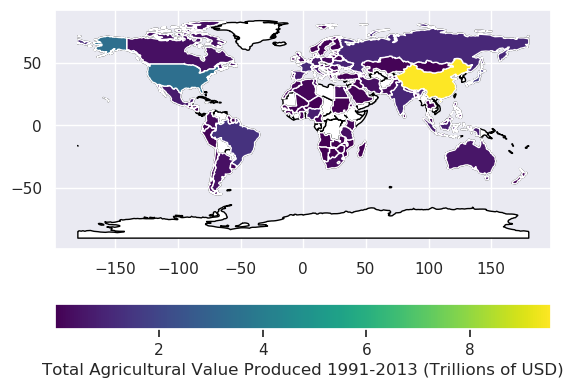

In [94]:
%%capture --no-display

base = world.plot(color = "white", edgecolor = 'black')

gdf_value.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Total Agricultural Value Produced 1991-2013 (Trillions of USD)",
                            'orientation':"horizontal"})
plt.show()

### Avg. Temperatures

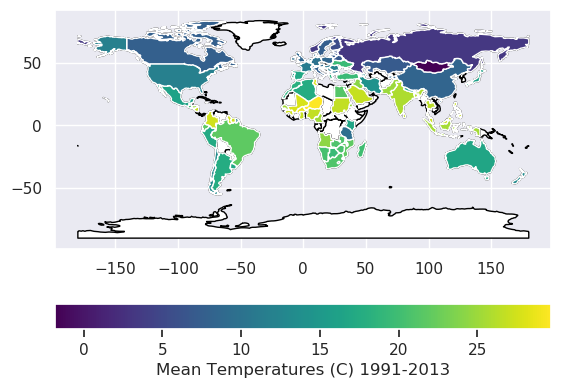

In [95]:
%%capture --no-display
# Taking mean of mean should be okay since our sample sizes are the same
val_country = df_clean.groupby(by="area")["avg_temp"].mean()


val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_temp = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)


base = world.plot(color = "white", edgecolor = 'black')

gdf_temp.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Temperatures (C) 1991-2013",
                            'orientation':"horizontal"})
plt.show()

### Avg. Rainfall

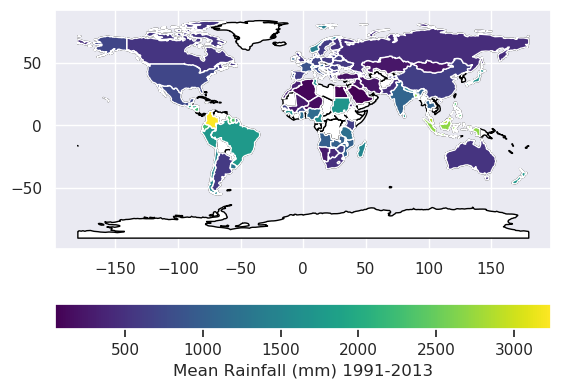

In [96]:
%%capture --no-display
# Taking mean of mean should be okay since our sample sizes are the same
val_country = df_clean.groupby(by="area")["avg_rain"].mean()

val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_rain = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)


base = world.plot(color = "white", edgecolor = 'black')

gdf_rain.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Rainfall (mm) 1991-2013",
                            'orientation':"horizontal"})
plt.show()

### Nitrogen for Ag Use

In [97]:
val_country = df_clean.groupby(by="area")["nitrogen"].mean()
val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_nitrogen = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

In [98]:
gdf_nitrogen['value'] = gdf_nitrogen[['value']]/1_000_000

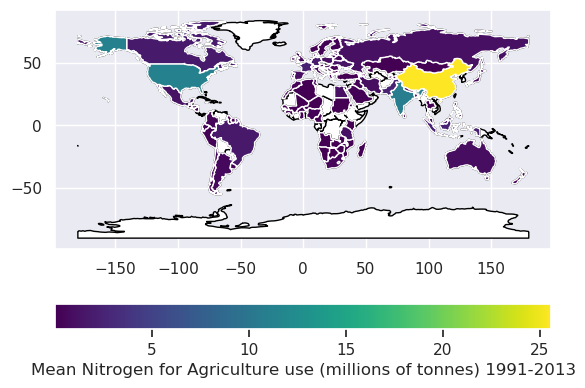

In [99]:
%%capture --no-display
base = world.plot(color = "white", edgecolor = 'black')

gdf_nitrogen.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Nitrogen for Agriculture use (millions of tonnes) 1991-2013",
                            'orientation':"horizontal"})

plt.show()

### Phosphate

In [100]:
val_country = df_clean.groupby(by="area")["phosphate"].mean()
val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_phos = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

In [101]:
gdf_phos['value'] = gdf_phos[['value']]/1_000_000

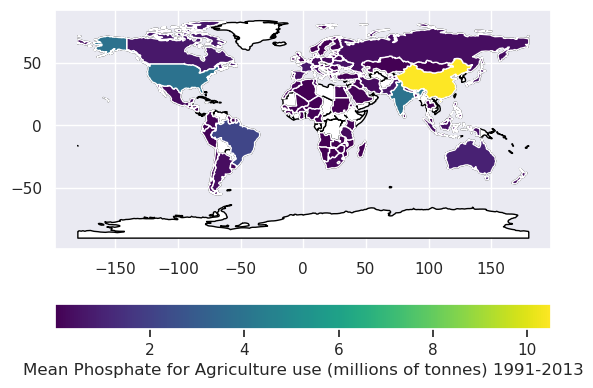

In [102]:
%%capture --no-display

base = world.plot(color = "white", edgecolor = 'black')

gdf_phos.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Phosphate for Agriculture use (millions of tonnes) 1991-2013",
                            'orientation':"horizontal"})
plt.show()

### Potassium

In [103]:
val_country = df_clean.groupby(by="area")["potassium"].mean()
val_country = pd.DataFrame(list(zip(countries, val_country)),
                           columns=['country', 'value'])

val_country = pd.merge(val_country, geos, how="inner", left_on=['country'], right_on=['name'])
val_country = val_country.drop(['name'], axis=1)


gdf_pot = geopandas.GeoDataFrame(
    val_country, geometry = val_country.geometry
)

In [104]:
gdf_pot['value'] = gdf_pot[['value']]/1_000_000

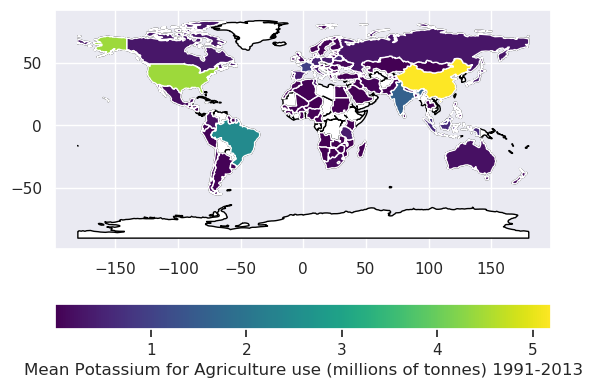

In [105]:
%%capture --no-display

base = world.plot(color = "white", edgecolor = 'black')

gdf_pot.plot(ax = base, column = "value",legend = True, cmap = "viridis",
               legend_kwds={'label': "Mean Potassium for Agriculture use (millions of tonnes) 1991-2013",
                            'orientation':"horizontal"})
plt.show()

## Categorical Anaylsis

#### "Area" and "item" are the only categorical variables

In [106]:
cat_df = pd.DataFrame(df, columns =['area', 'item'])

### "area" EDA:

In [107]:
#Finding the count of countries that are in the Area column:

print ("There are", cat_df['area'].nunique(), "different areas/countries in the dataset")

There are 103 different areas/countries in the dataset


In [108]:
#examining unique values of countries that are in the dataset
cat_df['area'].unique()


array(['Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh',
       'Belarus', 'Belgium', 'Botswana', 'Brazil', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cameroon', 'Canada',
       'Central African Republic', 'Chile', 'China', 'Colombia',
       'Croatia', 'Denmark', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Eritrea', 'Estonia', 'Finland', 'France',
       'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea',
       'Guyana', 'Honduras', 'Hungary', 'India', 'Indonesia', 'Iran',
       'Iraq', 'Ireland', 'Italy', 'Jamaica', 'Japan', 'Kazakhstan',
       'Kenya', 'Latvia', 'Lebanon', 'Lithuania', 'Madagascar', 'Malawi',
       'Malaysia', 'Mali', 'Mauritius', 'Mexico', 'Mongolia', 'Morocco',
       'Mozambique', 'Namibia', 'Nepal', 'Netherlands', 'New Zealand',
       'Nicaragua', 'Niger', 'Nigeria', 'Norway', 'Pakistan', 'Peru',
       'Philippines', 'Poland', 'Portugal', 'Qata

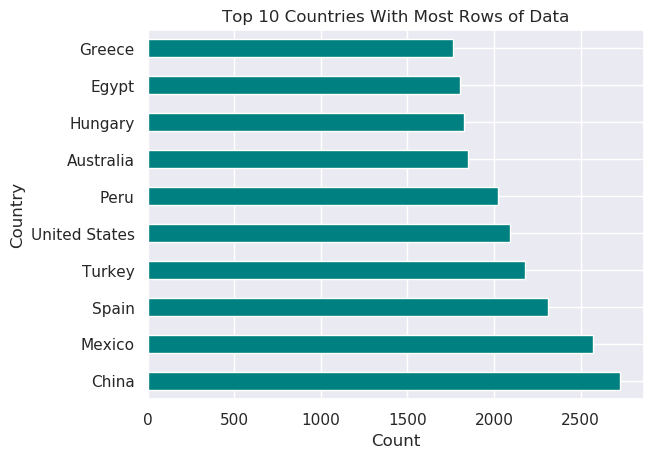

In [109]:
#frequency of each country: 
cat_df['area'].value_counts().head(10).plot(kind='barh', title= 'Top 10 Countries With Most Rows of Data', 
                                            color = 'teal')
plt.ylabel('Country')
plt.xlabel('Count')
plt.show()

#### Countries with most rows of data include China, Mexico, Spain & Turkey

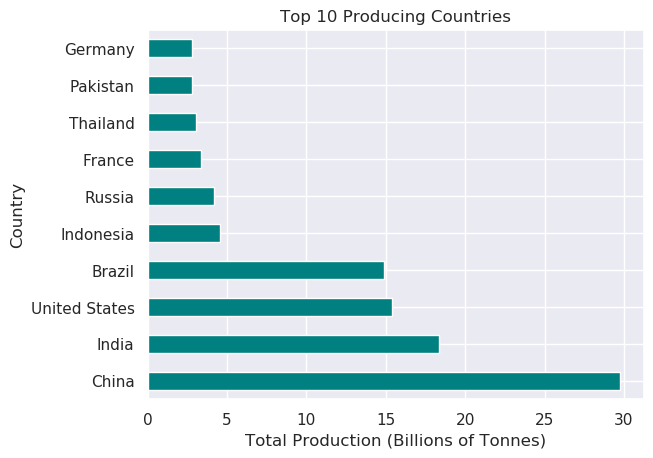

In [110]:
#Total production based on country
p_country = df.production.groupby(df['area']).sum().astype(int).reset_index(name="sum")
p_country = p_country.sort_values(by=['sum'], ascending=False).head(10)


p_country2 = p_country
p_country2['sum'] = p_country2['sum']/1_000_000_000

p_country2.plot(kind='barh', title= 'Top 10 Producing Countries', x=('area'), y = ('sum'), 
                color = 'teal', legend = None)



plt.xlabel('Total Production (Billions of Tonnes)')
plt.ylabel('Country')
plt.show()

#### Countries with most production are China, India, United States and Brazil

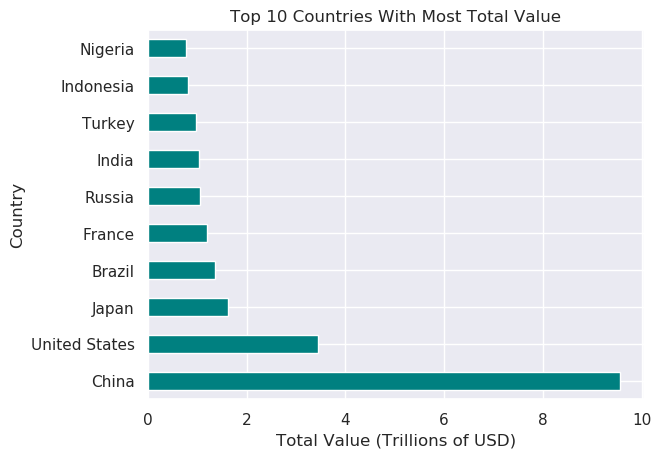

In [111]:
#Total value usd based on country
usd_country = df.total_value_usd.groupby(df['area']).sum().astype(int).reset_index(name="sum")
usd_country = usd_country.sort_values(by=['sum'], ascending=False).head(10)

usd_country2 = usd_country
usd_country2['sum'] = usd_country2['sum']/1_000_000_000_000
usd_country2.plot(kind='barh', title= 'Top 10 Countries With Most Total Value', x=('area'), y = ('sum'), 
                 color = 'teal', legend = None)

plt.ylabel('Country')
plt.xlabel('Total Value (Trillions of USD)')
plt.show()

#### Countries with highest total value USD include China, United States, Japan, and Brazil 

### "Item" EDA

In [112]:
#Finding the count of Items that are in the Item column:

print ("There are", cat_df['item'].nunique(), "different commodities in the dataset")

There are 190 different commodities in the dataset


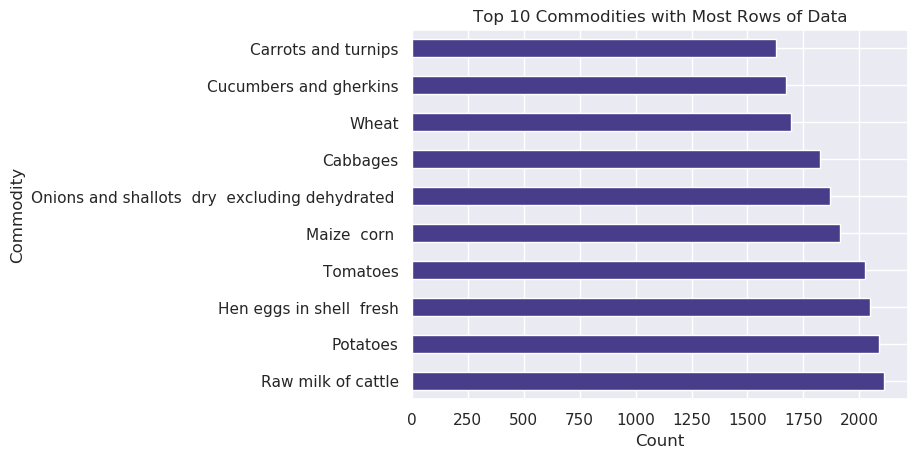

In [113]:
#frequency of each item: 
cat_df['item'].value_counts().head(10).plot(kind='barh', title= 'Top 10 Commodities with Most Rows of Data', 
                                            color = 'darkslateblue')

plt.xlabel('Count')
plt.ylabel('Commodity')
plt.show()

#### Top items with most rows of data are hen eggs in shell fresh, raw milk of acttle, potatoes, tomatoes, maize corn, etc. 

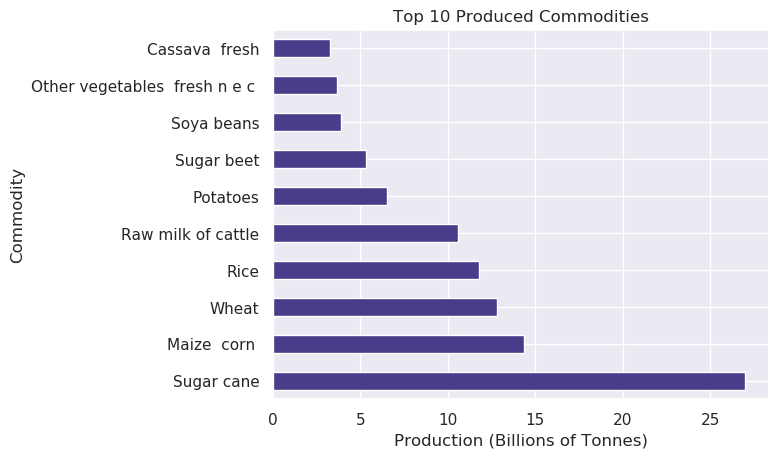

In [114]:
#Total production based on country
I_country = df.production.groupby(df['item']).sum().astype(int).reset_index(name="sum")
I_country = I_country.sort_values(by=['sum'], ascending=False).head(10)

I_country2 = I_country
I_country2['sum'] = I_country2['sum']/1_000_000_000

I_country2.plot(kind='barh', title= 'Top 10 Produced Commodities', x=('item'), y = ('sum'), 
                legend=None, color = 'darkslateblue')

plt.xlabel('Production (Billions of Tonnes)')
plt.ylabel('Commodity')
plt.show()

#### Top produced items include sugar cane, maize corn, wheat and rice

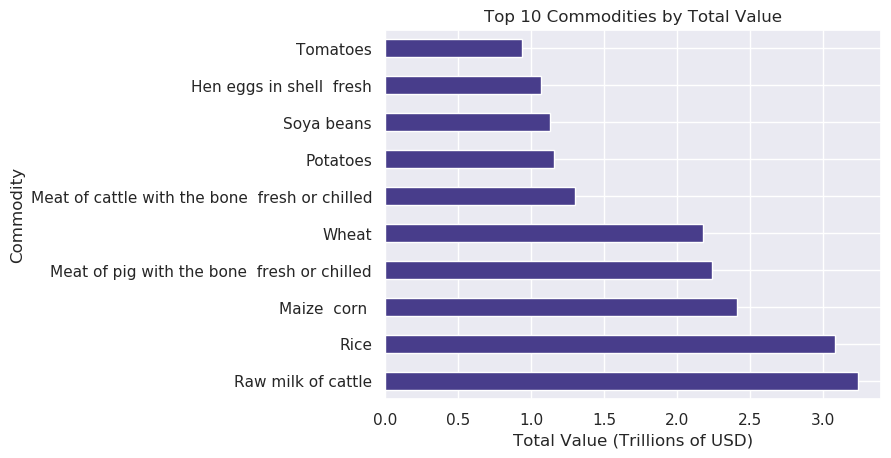

In [115]:
#Total value usd based on Item
usd_item = df.total_value_usd.groupby(df['item']).sum().astype(int).reset_index(name="sum")
usd_item = usd_item.sort_values(by=['sum'], ascending=False).head(10)

usd_item2 = usd_item
usd_item2['sum'] = usd_item2['sum']/1_000_000_000_000


usd_item2.plot(kind='barh', title= 'Top 10 Commodities by Total Value', x=('item'), y = ('sum'), 
               legend = None, color = 'darkslateblue')

plt.xlabel('Total Value (Trillions of USD)')
plt.ylabel('Commodity')
plt.show()

#### Items that have highest total value USD include raw milk of cattle, rice, maize corne and meat of pig with the bone fresh or chilled

### Outlier Analysis


In [116]:
summary =pd.DataFrame(df.describe())
summary

,year,production,nitrogen,phosphate,potassium,value,avg_rain,avg_temp,total_value_usd,lat,long
count,113454.000000,1.108840e+05,1.113050e+05,1.090010e+05,1.080210e+05,72779.000000,113454.000000,113454.000000,7.253600e+04,113454.000000,113454.000000
mean,2001.954545,1.337219e+06,1.429205e+06,5.956547e+05,3.933367e+05,987.891786,1021.496219,17.001938,4.636290e+08,24.034191,15.719130
std,6.778856,1.099610e+07,4.353015e+06,1.799397e+06,1.124213e+06,1620.114512,681.223616,7.231138,2.745589e+09,25.584214,60.775976
min,1991.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,51.000000,-3.370000,0.000000e+00,-41.500083,-107.991707
25%,1996.000000,5.789000e+03,4.270000e+04,1.800000e+04,9.286000e+03,226.200000,591.000000,10.330000,6.381282e+06,7.877396,-4.837979
50%,2001.500000,4.205850e+04,2.010000e+05,7.500000e+04,4.900000e+04,451.600000,748.000000,16.960000,3.418865e+07,31.172821,19.999962
75%,2008.000000,2.720000e+05,9.146600e+05,3.273870e+05,1.993220e+05,1089.000000,1485.000000,24.100000,1.806696e+08,42.638426,44.673665
max,2013.000000,7.680904e+08,3.080070e+07,1.425946e+07,9.217027e+06,40039.700000,3240.000000,30.420000,1.791078e+11,64.686314,172.834408


In [117]:
num_df = pd.DataFrame(df, columns =['production', 'nitrogen', 'phosphate', 'potassium', 'value', 'avg_rain','avg_temp', 'total_value_usd'])
num_df.head()

,production,nitrogen,phosphate,potassium,value,avg_rain,avg_temp,total_value_usd
0,10000.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN
1,1200.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN
2,3323.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN
3,12844.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN
4,0.0,22300.0,7700.0,1300.0,NaN,1485.0,15.36,NaN


#### Boxplot for numerical data:

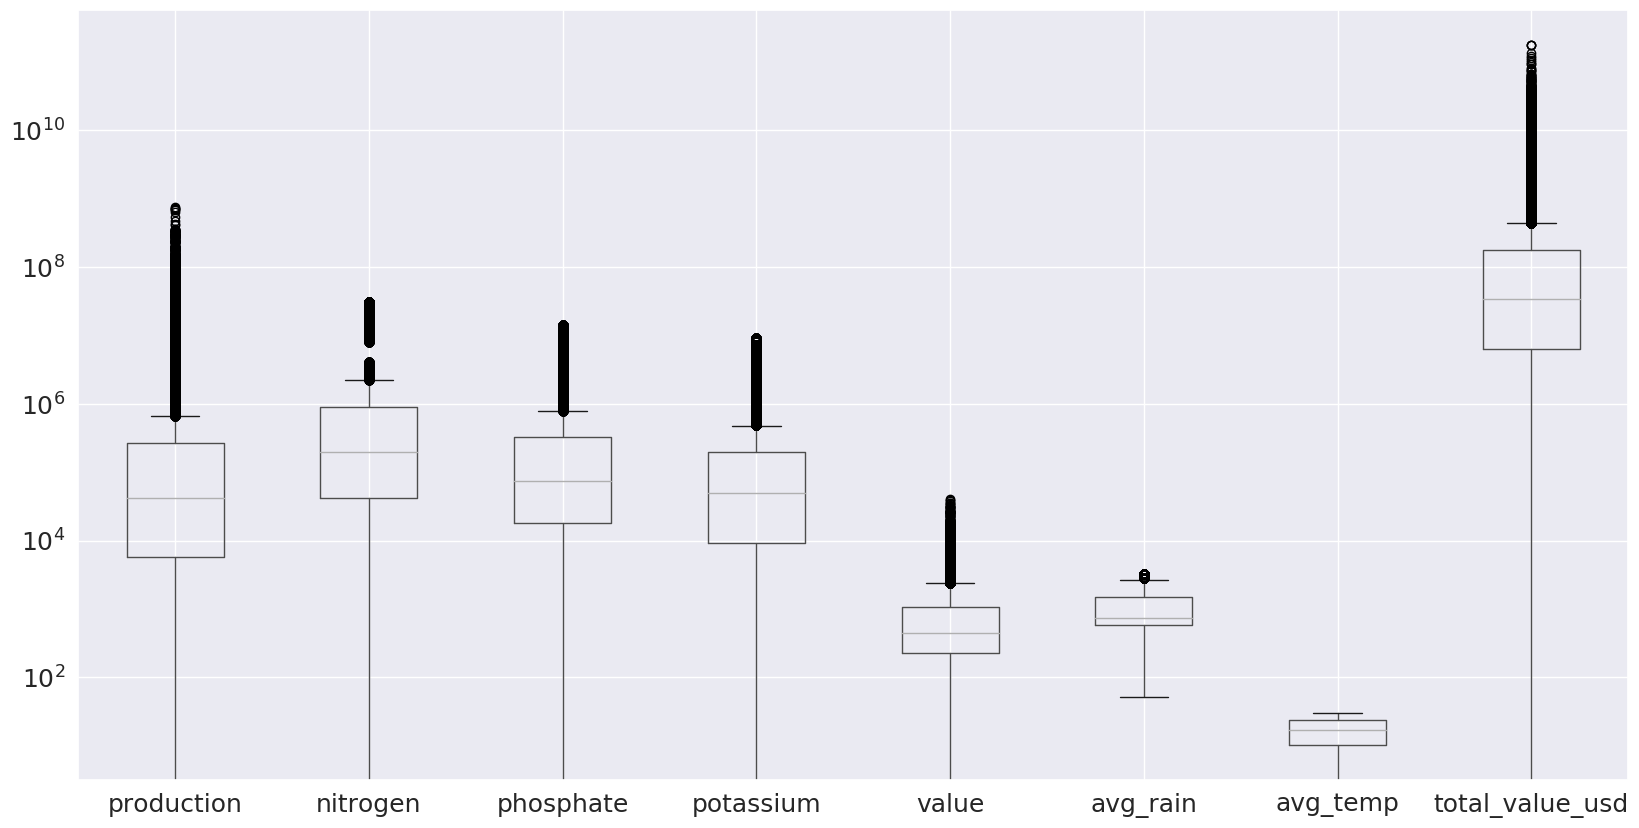

In [118]:
num_df.boxplot(figsize=(20,10), fontsize = 18)
plt.semilogy()
plt.show()

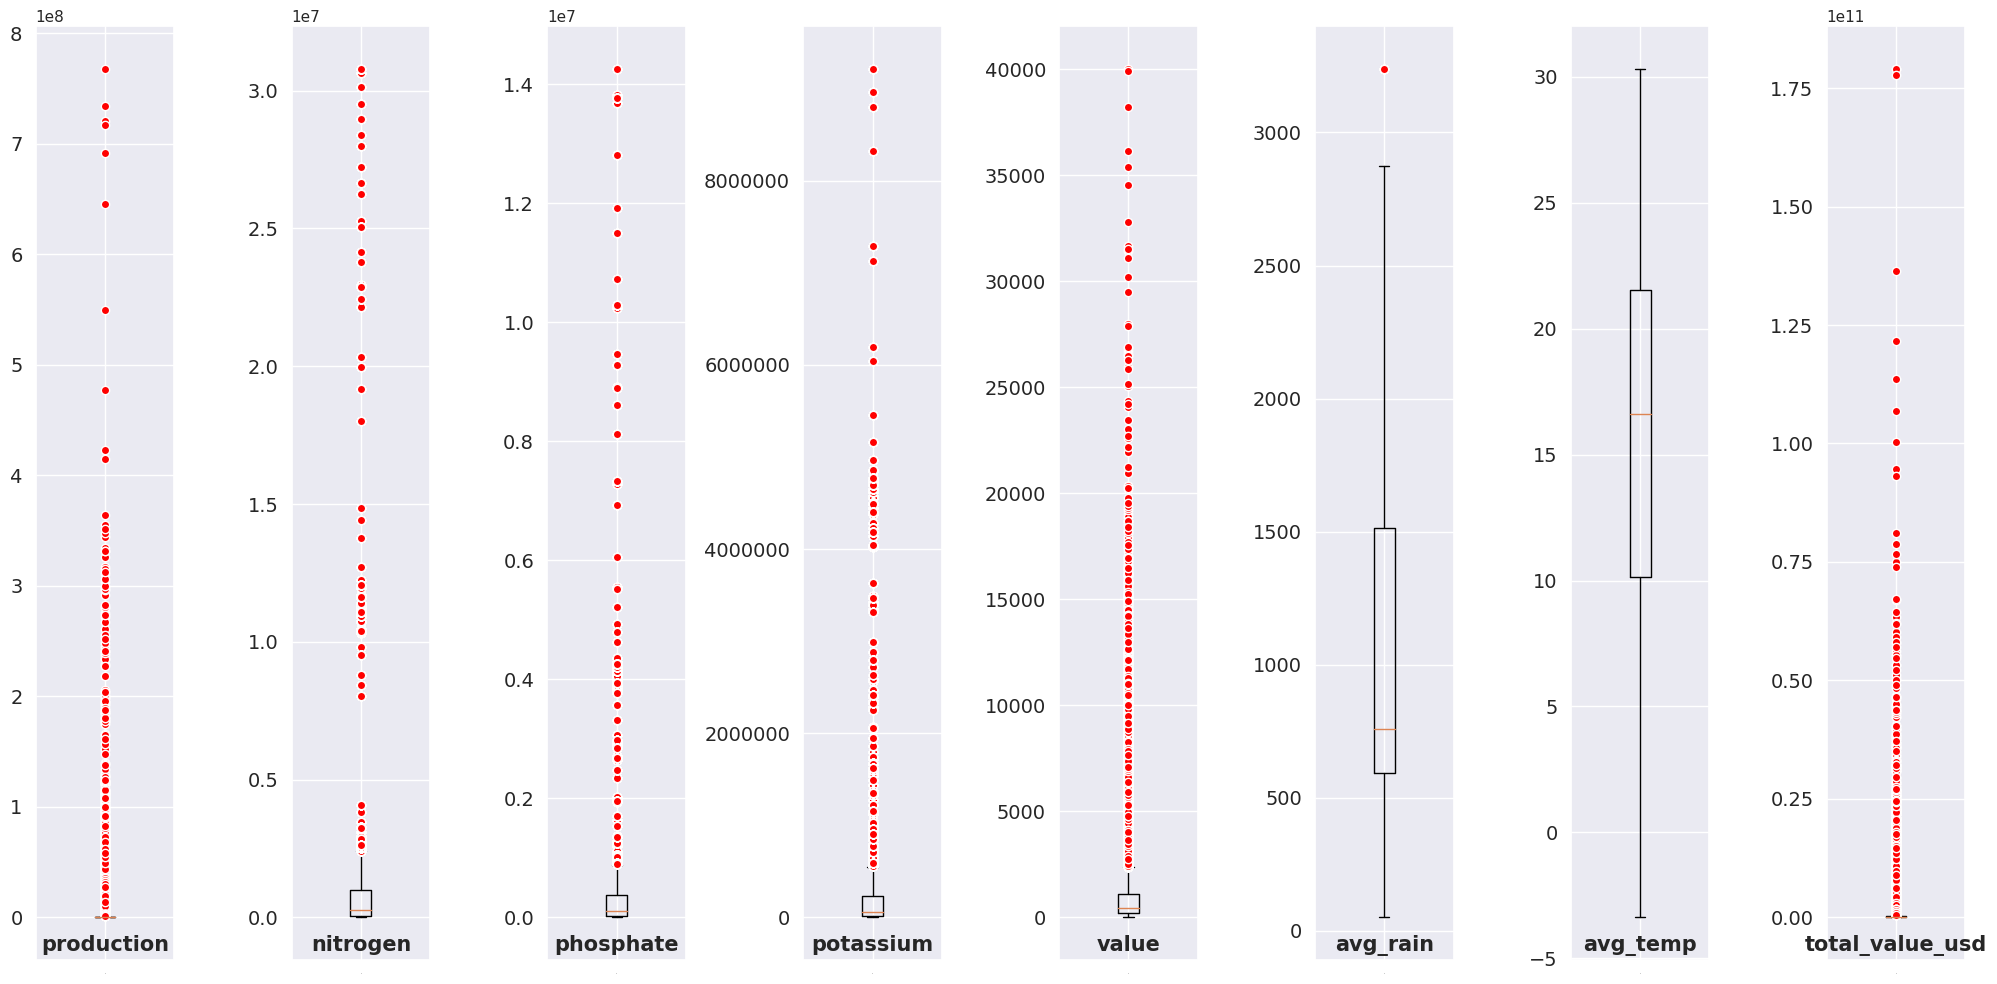

In [119]:
#Creating subplot of each column with its own scale
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

num_df = num_df.dropna()

fig, axs = plt.subplots(1, len(num_df.columns), figsize=(20,10))

for col, ax in enumerate(axs.flat):
    ax.boxplot(num_df.iloc[:,col], flierprops=red_circle)
    ax.set_title(num_df.columns[col], fontsize=15, fontweight='bold', y = 0)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize = 0)
    
plt.tight_layout()
plt.show()

#### It looks like most of the numerical columns have a large amount of outliers. Outliers should be kept considering significant amount of data. Average rain and average temp could possibly be resolved for outliers.

## Data Preparation:
We will not need the production, value, area, or year columns for modeling. Production and value were only used to create total_value_usd, area will be represented numerically through lat and long, and we are not doing any time series forecasting.

In [120]:
df_model = df_clean.drop(['production', 'value', 'area'], axis=1)

### Creating ratio features for the fertilizer columns:

In [121]:
#specifying the fertilizer columns to sum
cols = ['nitrogen', 'phosphate', 'potassium']

#setting up columm for sum:
df_model['fertilizer_sum'] = df_model[cols].sum(axis=1)

#creating ratio columns:

df_model["nitrogen_ratio"] = df_model["nitrogen"]/df_model["fertilizer_sum"]
df_model["phosphate_ratio"] = df_model["phosphate"]/df_model["fertilizer_sum"]
df_model["potassium_ratio"] = df_model["potassium"]/df_model["fertilizer_sum"]

# Drop the old fertilizer variables
df_model = df_model.drop(['nitrogen','phosphate','potassium','fertilizer_sum'], axis=1)

### One hot encode categorical data

In [122]:
cat = df_model[['item']]

ohe = OneHotEncoder(sparse = False).fit(cat)
cat_data = ohe.transform(cat)
cat_df = pd.DataFrame(cat_data, columns = ohe.get_feature_names(['item'])).reset_index(drop = True)

# Join to rest of data
df_model_num = df_model.drop(columns=['item'], axis = 1).reset_index(drop=True)
df_model2 = pd.concat([df_model_num, cat_df], axis = 1)

### Splitting Data

We will based on the year, since we'll need to include every commodity for each country and year to generate accurate rating metrics

In [123]:
# Split based on years
train = df_model2[df_model2['year'] <=2011]
val = df_model2[df_model2['year'] == 2012]
test = df_model2[df_model2['year'] == 2013]

# Split training from test and val
X_train = train.drop(['total_value_usd'], axis =1)
y_train = train['total_value_usd']

X_val = val.drop(['total_value_usd'], axis =1)
y_val = val['total_value_usd']

X_test = test.drop(['total_value_usd'], axis =1)
y_test = test['total_value_usd']



# Ensure we split correctly
total = df_model2.shape[0]

print("Train df size: ", X_train.shape[0], " (", round(X_train.shape[0]/total*100, 2), " percent of the total.)", sep='')
print("Test df size: ", X_test.shape[0], " (", round(X_test.shape[0]/total*100, 2), " percent of the total.)", sep='')
print("Val df size: ", X_val.shape[0], " (", round(X_val.shape[0]/total*100, 2), " percent of the total.)", sep='')

Train df size: 65572 (90.4 percent of the total.)
Test df size: 3444 (4.75 percent of the total.)
Val df size: 3520 (4.85 percent of the total.)


In [124]:
# Removing year that I needed to keep for future 
test_year = X_test['year']
X_test = X_test.drop(columns = ['year'], axis =1)
X_train = X_train.drop(columns = ['year'], axis =1)
X_val = X_val.drop(columns = ['year'], axis = 1)

### Set up scaler and imputer for future modeling pipeline

In [125]:
scaler = StandardScaler(with_mean = False)
imputer = SimpleImputer()

# Modeling

### Create Sparse Matrix
We were having memory issues with dense df's, we'll train with sparse matrices to prevent crashing

In [126]:
X_train_sparse = scipy.sparse.csr_matrix(X_train.values)

### Baseline Linear Regression

In [127]:
# Create modeling pipeline
clf = Pipeline(steps = [('scaler', scaler), ('imputer', imputer), 
                        ('linreg', LinearRegression())])



linreg = clf.fit(X_train_sparse, y_train)

# Predict
y_pred = linreg.predict(X_test)

In [128]:
%%capture --no-display
# Create ranking deployment

# First fix years issue
results = X_test.copy()
results['year'] = test_year

# Join the predicitons
results['pred'] = y_pred

# Reverse the one hot encoding
reverse_onehot = results.iloc[: ,7:195].idxmax(1)
results2 = results.iloc[:, np.r_[0:7,195:197]]
results2['item'] = pd.Series(reverse_onehot)
results2['item'] = results2['item'].str.replace("item_", "")

results2['base_rank'] = results2.groupby(['lat','long', 'year'])['pred'].rank(method="first").astype(int)
baseline_rankings = results2.sort_values(by=['lat','long','year','base_rank'])
baseline_rankings = baseline_rankings[["lat","long", "year", "item", "base_rank"]]

### ElasticNet Regression

In [129]:
%%capture --no-display
# Create pipeline
enet = ElasticNet()
enet_pipe = Pipeline(steps = [('scaler', scaler), ('imputer', imputer), 
                        ('enet', enet)])

# Hyperparameter tuning
alpha = np.arange(0, 1, 0.1)
l1_ratio = [1e-3, 1e-2, 1e-1, 0, 1, 10, 100]
params = dict(enet__alpha=alpha,
              enet__l1_ratio=l1_ratio)

enet_tuned = RandomizedSearchCV(enet_pipe,params, n_jobs = -1, random_state = 1)
enet_tuned.fit(X_train_sparse, y_train)
enet_tuned.best_params_

{'enet__l1_ratio': 0, 'enet__alpha': 0.9}

In [130]:
# Save the final model for faster use in future
enet_final = ElasticNet(l1_ratio = 1, alpha = 0.9)
enet_reg = enet_pipe.fit(X_train_sparse, y_train)
enet_pred = enet_reg.predict(X_test)

In [131]:
%%capture --no-display
# Convert to ranking for eval

# First fix years issue
results = X_test.copy()
results['year'] = test_year

# Join the predicitons
results['pred'] = enet_pred

# Reverse the one hot encoding
reverse_onehot = results.iloc[: ,7:195].idxmax(1)
results2 = results.iloc[:, np.r_[0:7,195:197]]
results2['item'] = pd.Series(reverse_onehot)
results2['item'] = results2['item'].str.replace("item_", "")

results2['enet_rank'] = results2.groupby(['lat','long', 'year'])['pred'].rank(method="first").astype(int)
enet_rankings = results2.sort_values(by=['lat','long','year','enet_rank'])
enet_rankings = enet_rankings[["lat","long", "year", "item", "enet_rank"]]

# Sagemaker Modeling
Transfer our training data to s3

In [135]:
X_train_sage = pd.concat([y_train,X_train], axis =1)
X_train_sage.describe()

,total_value_usd,avg_rain,avg_temp,lat,long,nitrogen_ratio,phosphate_ratio,potassium_ratio,item_Abaca manila hemp raw,item_Agave fibres raw n e c,...,item_Triticale,item_Tung nuts,item_Unmanufactured tobacco,item_Vanilla raw,item_Vetches,item_Walnuts in shell,item_Watermelons,item_Wheat,item_Yams,item_Yautia
count,6.557200e+04,65572.000000,65572.000000,65572.000000,65572.000000,65399.000000,64196.000000,63957.000000,65572.000000,65572.000000,...,65572.000000,65572.000000,65572.000000,65572.000000,65572.000000,65572.000000,65572.000000,65572.000000,65572.000000,65572.000000
mean,4.219073e+08,1033.760218,16.417136,25.483692,12.940966,0.599605,0.236916,0.171621,0.000610,0.000381,...,0.005216,0.000229,0.013588,0.000702,0.002089,0.006466,0.010645,0.019353,0.002791,0.000351
std,2.382889e+09,676.632433,7.094941,26.142710,64.047171,0.152920,0.114588,0.110816,0.024691,0.019522,...,0.072031,0.015123,0.115774,0.026477,0.045662,0.080153,0.102624,0.137763,0.052755,0.018725
min,0.000000e+00,51.000000,-3.040000,-41.500083,-107.991707,0.073218,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.099947e+06,593.000000,10.140000,9.600036,-8.135352,0.510230,0.163498,0.090764,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.213449e+07,758.000000,16.630000,33.843941,19.134422,0.604749,0.216809,0.162856,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.708781e+08,1500.000000,21.590000,45.985213,42.352833,0.684857,0.286889,0.237417,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.791078e+11,3240.000000,30.320000,64.686314,172.834408,1.000000,0.855221,0.824135,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### PReparing the Data Files

In [226]:
import io
import os
from sagemaker.inputs import TrainingInput
from sagemaker.amazon.amazon_estimator import RecordSet
from sagemaker import image_uris
from sagemaker.estimator import Estimator
from sagemaker.tuner import HyperparameterTuner, CategoricalParameter
# Define IAM role
role #Predefined initially by Hunter

# Define S3 bucket and prefix
bucket # Predefined by Hunter
prefix = 'FactorizationMachines'

#Splitting the X_TRAIN_SAGE into Train and Validation (Test) sets.
train_df, validation_df = np.split(X_train_sage.sample(frac=1, random_state=1729), [int(0.9 * len(X_train_sage))])



Upload as CSV to Session S3 Bucket

In [227]:
# convert train_df and validation_df to CSV files in memory
train_buffer = io.StringIO()
train_df.to_csv(train_buffer, header=False, index=False)
train_buffer.seek(0)

val_buffer = io.StringIO()
validation_df.to_csv(val_buffer, header=False, index=False)
val_buffer.seek(0)

# upload CSV files to S3
s3_resource = boto3.resource('s3')
s3_train_data = s3_resource.Object(bucket, f"{prefix}/train/train.csv")
s3_train_data.put(Body=train_buffer.getvalue())

s3_validation_data = s3_resource.Object(bucket, f"{prefix}/validation/validation.csv")
s3_validation_data.put(Body=val_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '8WXX5K9E2A3H82JH',
  'HostId': 'JeoPjEa1EAQuOjjYhc+7h9kS5813da/H7W1xRYG2XOb7Y4+MGN9aaGAIGWkoXhENzenWsmcK/4k=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'JeoPjEa1EAQuOjjYhc+7h9kS5813da/H7W1xRYG2XOb7Y4+MGN9aaGAIGWkoXhENzenWsmcK/4k=',
   'x-amz-request-id': '8WXX5K9E2A3H82JH',
   'date': 'Tue, 04 Apr 2023 02:00:14 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"0c583847f5a4d80bbc24829527269ab0"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"0c583847f5a4d80bbc24829527269ab0"',
 'ServerSideEncryption': 'AES256'}

In [231]:
train_labels = np.array(train_df['total_value_usd'].astype('float32'))
validation_labels = np.array(validation_df['total_value_usd'].astype('float32'))

# create a TrainingInput object for train and validation data
#train_data = TrainingInput(s3_data=s3_train_data.key, content_type='text/csv')
#validation_data = TrainingInput(s3_data=s3_validation_data.key, content_type='text/csv')

#train_records = RecordSet(train_df.values.astype('float32'), labels=train_labels.astype('float32'))
#validation_records = RecordSet(validation_df.values.astype('float32'), labels=validation_labels.astype('float32'))

train_df.insert(0, 'label', train_labels)
validation_df.insert(0, 'label', validation_labels)

#train_records = RecordSet(train_df.values.astype('float32'))
#validation_records = RecordSet(validation_df.values.astype('float32'))

train_records = RecordSet(train_df.values.astype('float32'), num_records=train_df.shape[0], feature_dim=train_df.shape[1])
validation_records = RecordSet(validation_df.values.astype('float32'), num_records=validation_df.shape[0], feature_dim=validation_df.shape[1])

train_input = sagemaker.inputs.TrainingInput(train_records, content_type='text/csv')
validation_input = sagemaker.inputs.TrainingInput(validation_records, content_type='text/csv')

In [228]:
import csv
# Read the CSV file from S3
bucket_name = bucket
file_key = f"{prefix}/validation/validation.csv"


response = s3_client.get_object(Bucket=bucket_name, Key=file_key)
csv_bytes = response['Body'].read().decode('utf-8')

# Replace blank or null values with 0s
csv_data = []
for row in csv.reader(io.StringIO(csv_bytes)):
    new_row = []
    for value in row:
        if value == '' or value is None:
            new_row.append('0')
        else:
            new_row.append(value)
    csv_data.append(new_row)

# Write the updated CSV back to S3
csv_buffer = io.StringIO()
writer = csv.writer(csv_buffer)
for row in csv_data:
    writer.writerow(row)
s3_client.put_object(Bucket=bucket_name, Key=file_key, Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'AZ59R5A61FEETC6R',
  'HostId': 'MktEbAwQ3KaNBbp6qi7zyBPdBxgN/bspIg7IDhFmTVeUCZIu2GCvgkE1z+W6Gtii5nqv67o2jLE=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'MktEbAwQ3KaNBbp6qi7zyBPdBxgN/bspIg7IDhFmTVeUCZIu2GCvgkE1z+W6Gtii5nqv67o2jLE=',
   'x-amz-request-id': 'AZ59R5A61FEETC6R',
   'date': 'Tue, 04 Apr 2023 02:00:22 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"88d0f201c8bf4219ac8325509bb5a213"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"88d0f201c8bf4219ac8325509bb5a213"',
 'ServerSideEncryption': 'AES256'}

In [229]:
import csv
# Read the CSV file from S3
bucket_name = bucket
file_key = f"{prefix}/train/train.csv"


response = s3_client.get_object(Bucket=bucket_name, Key=file_key)
csv_bytes = response['Body'].read().decode('utf-8')

# Replace blank or null values with 0s
csv_data = []
for row in csv.reader(io.StringIO(csv_bytes)):
    new_row = []
    for value in row:
        if value == '' or value is None:
            new_row.append('0')
        else:
            new_row.append(value)
    csv_data.append(new_row)

# Write the updated CSV back to S3
csv_buffer = io.StringIO()
writer = csv.writer(csv_buffer)
for row in csv_data:
    writer.writerow(row)
s3_client.put_object(Bucket=bucket_name, Key=file_key, Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'R22BS0GMVE8X7HWZ',
  'HostId': 'p6oWRCiV6kkHvFq5T6e4l+egmk29h/hzPWhpr8IP3T7uOig0/7CyUck5P2b0rTScHLCvHbYShU8=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'p6oWRCiV6kkHvFq5T6e4l+egmk29h/hzPWhpr8IP3T7uOig0/7CyUck5P2b0rTScHLCvHbYShU8=',
   'x-amz-request-id': 'R22BS0GMVE8X7HWZ',
   'date': 'Tue, 04 Apr 2023 02:00:34 GMT',
   'x-amz-server-side-encryption': 'AES256',
   'etag': '"3e26133fa36c07c064a11d7eeedd6bc5"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"3e26133fa36c07c064a11d7eeedd6bc5"',
 'ServerSideEncryption': 'AES256'}

In [230]:
print(bucket)
print(prefix)

sagemaker-us-east-1-954372485966
FactorizationMachines


Setting up Hyper Parameters

Factorization Machines Model using AWS Container

In [232]:
# Set up hyperparameters
hyperparameters = {
    "feature_dim": str(len(train_df.columns)),
    "num_factors": "10",
    "epochs": "10",
    "mini_batch_size": "197",
    'predictor_type': 'regressor'
}

# Set up input data
train_input = TrainingInput(
    f"s3://{bucket}/{prefix}/train", #"s3://<S3 bucket>/<prefix>/train",
    content_type="text/csv",
)

validation_input = TrainingInput(
        f"s3://{bucket}/{prefix}/train", #"s3://<S3 bucket>/<prefix>/validation",
    content_type="text/csv",
)

# Set up Estimator
fm_container = image_uris.retrieve("factorization-machines", region)
estimator = Estimator(
    image_uri=fm_container,
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",
    hyperparameters=hyperparameters,
    sagemaker_session=sess,
)

# Train the model
estimator.fit({"train": train_input, "validation": validation_input})


2023-04-04 02:01:02 Starting - Starting the training job...
2023-04-04 02:01:31 Starting - Preparing the instances for trainingProfilerReport-1680573662: InProgress
......
2023-04-04 02:02:21 Downloading - Downloading input data...
2023-04-04 02:03:00 Training - Downloading the training image..................
2023-04-04 02:06:05 Uploading - Uploading generated training model
2023-04-04 02:06:05 Failed - Training job failed
Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/04/2023 02:05:50 INFO 140624445130560] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'epochs': 1, 'mini_batch_size': '1000', 'use_bias': 'true', 'use_linear': 'true', 'bias_lr': '0.1', 'linear_lr': '0.001', 'factors_lr': '0.0001', 'bias_wd': '0.01', 'linear_wd': '0.001', 'factors_wd': '0.00001', 'bias_init_method': 'normal', 'bias_init_sigma': '0.01', 'linear_init_method': 'normal', 'linear_init_si

UnexpectedStatusException: Error for Training job factorization-machines-2023-04-04-02-01-02-748: Failed. Reason: ClientError: Rows 1-197 in file /opt/ml/input/data/train/train.csv have different fields than the expected size 198., exit code: 2

In [197]:
#train_input.shape
#validation_input.shape

s3 = boto3.resource('s3')


train_object = s3.Object(bucket, f'{prefix}/train')
train_content = train_object.get()['Body'].read().decode('utf-8')
train_rows = train_content.strip().split('\n')
train_cols = train_rows[0].split(',')

validation_object = s3.Object(bucket, f'{prefix}/validation')
validation_content = validation_object.get()['Body'].read().decode('utf-8')
validation_rows = validation_content.strip().split('\n')
validation_cols = validation_rows[0].split(',')

train_dimensions = (len(train_rows), len(train_cols))
validation_dimensions = (len(validation_rows), len(validation_cols))

print("Train data dimensions:", train_dimensions)
print("Validation data dimensions:", validation_dimensions)

NoSuchKey: An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.

In [ ]:
# Hyperparameter Tuning
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name="validation:binary_classification_accuracy",
    hyperparameter_ranges={
        "learning_rate": CategoricalParameter(["0.001", "0.01", "0.1"]),
        "mini_batch_size": CategoricalParameter(["1000", "5000", "10000"]),
    },
    max_jobs=9,
    max_parallel_jobs=3,
)

tuner.fit({"train": train_input, "validation": validation_input})


Linear Learner Algorithm

In [217]:

import sagemaker
from sagemaker import LinearLearner
from sagemaker.inputs import TrainingInput

# Set up the paths for the output artifacts
output_path = f's3://{bucket}/{prefix}/output'
model_path = f'{output_path}/model'


# Set up the Linear Learner estimator
train_file = 'train.csv'
validation_file = 'validation.csv'
prefix = 'LinearLearnerModel'

#Splitting the X_TRAIN_SAGE into Train and Validation (Test) sets.
train_df, validation_df = np.split(X_train_sage.sample(frac=1, random_state=1729), [int(0.9 * len(X_train_sage))])
train_buffer = io.StringIO()
train_df.to_csv(train_buffer, header=False, index=False)
train_buffer.seek(0)

val_buffer = io.StringIO()
validation_df.to_csv(val_buffer, header=False, index=False)
val_buffer.seek(0)

# upload CSV files to S3
s3_resource = boto3.resource('s3')
s3_train_data = s3_resource.Object(bucket, f"{prefix}/train/train.csv")
s3_train_data.put(Body=train_buffer.getvalue())

s3_validation_data = s3_resource.Object(bucket, f"{prefix}/validation/validation.csv")
s3_validation_data.put(Body=val_buffer.getvalue())

# Set up the S3 URIs for the train and validation datasets
s3_train_uri = f's3://{bucket}/{prefix}/train/{train_file}'
s3_validation_uri = f's3://{bucket}/{prefix}/validation/{validation_file}'

print(s3_train_uri)
print(s3_validation_uri)
print(train_file)
print(bucket)
print(prefix)
print(validation_file)
# Upload the datasets to S3
train_input = sess.upload_data(train_file, bucket=bucket, key_prefix=prefix+'/train/')
validation_input = sess.upload_data(validation_file, bucket=bucket, key_prefix=prefix+'/validation/')

print(train_input)
print(validation_input)

# Create the RecordSet objects for both train and validation datasets
train_records = sagemaker.inputs.TrainingInput(s3_data=s3_train_uri, content_type='text/csv')
validation_records = sagemaker.inputs.TrainingInput(s3_data=s3_validation_uri, content_type='text/csv')

print(train_records)
print(validation_records)


s3://sagemaker-us-east-1-954372485966/LinearLearnerModel/train/train.csv
s3://sagemaker-us-east-1-954372485966/LinearLearnerModel/validation/validation.csv
train.csv
sagemaker-us-east-1-954372485966
LinearLearnerModel
validation.csv


FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

In [213]:

# Instantiate the LinearLearner estimator
linear = sagemaker.estimator.Estimator(image_uri=sagemaker.amazon.amazon_estimator.get_image_uri(region, 'linear-learner'),
                                       role=role,
                                       instance_count=1,
                                       instance_type='ml.m5.large',
                                       output_path=f's3://{bucket}/{prefix}/output')

# Set the hyperparameters
linear.set_hyperparameters(feature_dim=str(len(train_df.columns)),
                           predictor_type='regressor',
                           mini_batch_size=32)

# Train the model
linear.fit({'train': train_records, 'validation': validation_records})

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


NameError: name 'feature_dim' is not defined

In [ ]:
output_location = 's3://{}/{}/output/'.format(bucket, prefix)
hyperparameters = {
    'feature_dim': str(len(train_df.columns)),
    'num_factors': 64,
    'epochs': 100,
    'mini_batch_size': 1000,
    'predictor_type': 'regressor'  # or 'binary_classifier'
}

# set up the estimator
estimator = sagemaker.estimator.Estimator(
    image_uri=sagemaker.image_uris.retrieve('factorization-machines', sagemaker_session.boto_region_name),
    role=role, 
    instance_count=1, 
    instance_type='ml.c4.xlarge', 
    output_path=output_location,
    hyperparameters=hyperparameters,
    sagemaker_session=sagemaker_session
)

# start the training job
train_input = TrainingInput(train_s3_path, content_type='text/csv')
validation_input = TrainingInput(validation_s3_path, content_type='text/csv')
estimator.fit({'train': train_input, 'validation': validation_input})


In [133]:
import io
s3_client = boto3.client("s3")
BUCKET = "sagemaker-studio-998234604495-nyhifbo32oo"
KEY = "model/Train.csv"
response = s3_client.get_object(Bucket=BUCKET, Key=KEY)

with io.StringIO() as csv_buffer:
    X_train_sage.to_csv(csv_buffer, index=False, header=False)

    response = s3_client.put_object(
        Bucket=BUCKET, Key=KEY, Body=csv_buffer.getvalue()
    )

ClientError: An error occurred (AccessDenied) when calling the PutObject operation: Access Denied

In [ ]:
# set up our parameters
s3_input_train = sagemaker.inputs.TrainingInput(s3_data=\
        's3://{}/model/Train'.format(BUCKET), content_type='csv')

## XGBoost
Set up the container

In [ ]:
# Define IAM role
role = get_execution_role()

# set the region of the instance
my_region = boto3.session.Session().region_name 

# this line automatically looks for the XGBoost image URI and 
# builds an XGBoost container.
xgboost_container = sagemaker.image_uris.retrieve("xgboost", 
                                                  my_region, 
                                                  "latest")

print("Success - the MySageMakerInstance is in the " + my_region + \
      " region. You will use the " + xgboost_container + \
      " container for your SageMaker endpoint.")

Define the hyper parameters

In [ ]:
sess = sagemaker.Session()
xgb = sagemaker.estimator.Estimator(xgboost_container,role, 
                                    instance_count=1, 
                                    instance_type='ml.m5.large',
                                    output_path='s3://{}/output'.format(BUCKET),
                                    sagemaker_session=sess)
# parse in the hyperparameters
xgb.set_hyperparameters(max_depth=5,min_child_weight=2, lambda_bias = 0.5,
                        subsample=0.9,silent=0,
                        objective='reg:linear',num_round=100)

Train

In [ ]:
xgb.fit({'train': s3_input_train})

Deploy and get the predictions

In [ ]:
xgb_pred_deploy = xgb.deploy(initial_instance_count = 1,
                             instance_type='ml.m5.large')

In [ ]:
from sagemaker.serializers import CSVSerializer


X_test_array = X_test.values

xgb_pred_deploy.serializer = CSVSerializer()

predictions = xgb_pred_deploy.predict(X_test_array).decode('utf-8')

xgb_pred = np.fromstring(predictions[1:], sep=',')
xgb_pred.size

In [ ]:
%%capture --no-display
# Convert to ranking for eval

# First fix years issue
results = X_test.copy()
results['year'] = test_year

# Join the predicitons
results['pred'] = xgb_pred

# Reverse the one hot encoding
reverse_onehot = results.iloc[: ,7:195].idxmax(1)
results2 = results.iloc[:, np.r_[0:7,195:197]]
results2['item'] = pd.Series(reverse_onehot)
results2['item'] = results2['item'].str.replace("item_", "")

results2['xgb_rank'] = results2.groupby(['lat','long', 'year'])['pred'].rank(method="first").astype(int)
xgb_rankings = results2.sort_values(by=['lat','long','year','xgb_rank'])
xbg_rankings = xgb_rankings[["lat","long", "year", "item", "xgb_rank"]]

# Model Evaluation

Get the actual rankings from the test dataset

In [ ]:
%%capture --no-display
# Create test df ranks for calculating metrics

# First fix years issue
test_rank = X_test.copy()
test_rank['year'] = test_year

# Join the predicitons
test_rank['pred'] = y_test

# Reverse the one hot encoding
reverse_onehot = test_rank.iloc[: ,7:195].idxmax(1)
test_rank2 = test_rank.iloc[:, np.r_[0:7,195:197]]
test_rank2['item'] = pd.Series(reverse_onehot)
test_rank2['item'] = test_rank2['item'].str.replace("item_", "")

test_rank2['group_rank'] = test_rank2.groupby(['lat','long', 'year'])['pred'].rank(method="first").astype(int)
test_rank_final = test_rank2.sort_values(by=['lat','long','year','group_rank'])

test_rank_final = test_rank_final[["lat","long", "year", "item", "group_rank"]]

## Root Mean Square Error of ranking

In [ ]:
from sklearn.metrics import mean_squared_error
import math

# Baseline
base_merge = pd.merge(test_rank_final, baseline_rankings, how = "inner", left_on=['lat', 'long', 'year', 'item'], right_on=['lat', 'long', 'year', 'item'])
base_mse = mean_squared_error(base_merge['group_rank'], base_merge['base_rank'])
base_rmse = math.sqrt(base_mse)

# Enet
enet_merge = pd.merge(test_rank_final, enet_rankings, how = "inner", left_on=['lat', 'long', 'year', 'item'], right_on=['lat', 'long', 'year', 'item'])
enet_mse = mean_squared_error(enet_merge['group_rank'], enet_merge['enet_rank'])
enet_rmse = math.sqrt(enet_mse)

# XGBoost
xgb_merge = pd.merge(test_rank_final, xgb_rankings, how = "inner", left_on=['lat', 'long', 'year', 'item'], right_on=['lat', 'long', 'year', 'item'])
xgb_mse = mean_squared_error(xgb_merge['group_rank'], xgb_merge['xgb_rank'])
xgb_rmse = math.sqrt(xgb_mse)

## Spearman Correlation Coefficient

In [ ]:
from scipy.stats import spearmanr

base_rho, base_p = spearmanr(base_merge['group_rank'], base_merge['base_rank'])
enet_rho, enet_p = spearmanr(enet_merge['group_rank'], enet_merge['enet_rank'])
xgb_rho, xgb_p = spearmanr(xgb_merge['group_rank'], xgb_merge['xgb_rank'])

Combine everyting into a df to plot

In [ ]:
Models = ['Lin. Reg.', 'ENet', 'XGBoost']
RMSE = [base_rmse, enet_rmse, xgb_rmse]
rho = [base_rho, enet_rho, xgb_rho]
p = [base_p, enet_p, xgb_p]

Results = pd.DataFrame(list(zip(Models, RMSE, rho, p)),
                       columns = ['Model', 'RMSE', 'Spearman_r', 'Spearman_p'])
Results

### RMSE Plot

In [ ]:
Res_rmse = Results.sort_values(by=['RMSE'], ascending=False)

sns.barplot(y = 'Model', x = 'RMSE', data = Res_rmse, color = 'teal')
plt.title("Root Mean Squared Error of Rankings")
plt.show()

### Spearman Plot

In [ ]:
Res_spear = Results.sort_values(by=['Spearman_r'], ascending=False)

sns.barplot(y = 'Model', x = 'Spearman_r', data = Res_spear, color = 'teal')
plt.xlabel('Spearman Rank Correlation')
plt.title("Spearman Rank Correlations (all p-values were zero)")
plt.show()

# Tensorflow Stuff:

We should be able to delete the tensor flow stuff unless someone wants to keep trying on it

#### Preparing the dataframe to to convert to tensor:

In [ ]:
numeric_feature_names = ['avg_rain', 'avg_temp', 'total_value_usd',  'lat', 'long', 'nitrogen_ratio', 'phosphate_ratio', 'potassium_ratio']
numeric_features = df_model[numeric_feature_names]
numeric_features.head()

In [ ]:
np.array(numeric_features)

In [ ]:
num_data = tf.convert_to_tensor(numeric_features)

#### Building Recommender Model:

In [ ]:
df_model =model_df.map(lambda x: {
    "item": x["item"],
    "avg_rain": x["avg_rain"],
    "avg_temp": x["avg_temp"],
    "total_value_usd": x["total_value_usd"],
    "lat": x["lat"],
    "long": x["long"],
    "nitrogen_ratio": x["nitrogen_ratio"],
     "phosphate_ratio": x["phosphate_ratio"],
    "potassium_ratio": x["potassium_ratio"]
}) 

In [ ]:
tf.random.set_seed(508)
shuffled = df_model.shuffle(100_000, seed=508, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000_.take(20_000)